In [ ]:
# ------------------------------------
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.
# ------------------------------------

"""
DESCRIPTION:
    This sample demonstrates how to use agent operations with code interpreter from
    the Azure Agents service using a synchronous client.

USAGE:
    Before running the sample:

    pip install azure-ai-projects azure-ai-agents azure-identity

    Set these environment variables with your own values:
    1) PROJECT_ENDPOINT - The Azure AI Project endpoint, as found in the Overview
                          page of your Azure AI Foundry portal.
    2) MODEL_DEPLOYMENT_NAME - The deployment name of the AI model, as found under the "Name" column in
       the "Models + endpoints" tab in your Azure AI Foundry project.
"""

import os
from azure.ai.projects import AIProjectClient
from azure.ai.agents.models import CodeInterpreterTool
from azure.ai.agents.models import FilePurpose, MessageRole
from azure.identity import DefaultAzureCredential
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()
AIFOUNDRY_AGENT_PROJECT_NAME = os.getenv("AIFOUNDRY_AGENT_PROJECT_NAME")
AIFOUNDRY_AGENT_MODEL_DEPLOYMENT_NAME = os.getenv("AIFOUNDRY_AGENT_MODEL_DEPLOYMENT_NAME")


In [2]:
project_client = AIProjectClient(
    endpoint=AIFOUNDRY_AGENT_PROJECT_NAME,
    credential=DefaultAzureCredential(),
)


agents_client = project_client.agents

code_interpreter = CodeInterpreterTool()

# Create agent with code interpreter tool and tools_resources
agent = agents_client.create_agent(
    model=AIFOUNDRY_AGENT_MODEL_DEPLOYMENT_NAME,
    name="my-agent",
    instructions="You are helpful agent",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)
# [END upload_file_and_create_agent_with_code_interpreter]
print(f"Created agent, agent ID: {agent.id}")

thread = agents_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

# Create a message
message = agents_client.messages.create(
    thread_id=thread.id,
    role="user",
    content="Could you please create a bar chart for the operating profit using the inline data and provide the file to me? Company A: $1.2 million, Company B: $2.5 million, Company C: $3.0 million, Company D: $1.8 million",
)
print(f"Created message, message ID: {message.id}")

run = agents_client.runs.create_and_process(thread_id=thread.id, agent_id=agent.id)
print(f"Run finished with status: {run.status}")

if run.status == "failed":
    # Check if you got "Rate limit is exceeded.", then you want to get more quota
    print(f"Run failed: {run.last_error}")

# [START get_messages_and_save_files]
messages = agents_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

target_dir = f"{Path.cwd()}\\output\\"
for msg in messages:
    # Save every image file in the message
    for img in msg.image_contents:
        file_id = img.image_file.file_id
        file_name = f"operating_profit_bar_chart_inline_img.png"
        agents_client.files.save(file_id=file_id, file_name=file_name, target_dir=target_dir)
        print(f"Saved image file to: {target_dir} / {file_name}")

    # Print details of every file-path annotation
    for ann in msg.file_path_annotations:
        print("File Paths:")
        print(f"  Type: {ann.type}")
        print(f"  Text: {ann.text}")
        print(f"  File ID: {ann.file_path.file_id}")
        print(f"  Start Index: {ann.start_index}")
        print(f"  End Index: {ann.end_index}")
        file_name = f"operating_profit_bar_chart_inline_annotation.png"
        agents_client.files.save(file_id=ann.file_path.file_id, file_name=file_name, target_dir=target_dir)
# [END get_messages_and_save_files]

last_msg = agents_client.messages.get_last_message_text_by_role(thread_id=thread.id, role=MessageRole.AGENT)
if last_msg:
    print(f"Last Message: {last_msg.text.value}")

agents_client.delete_agent(agent.id)
print("Deleted agent")

Created agent, agent ID: asst_p6f4JytoM1haNxB2rKB2qayV
Created thread, thread ID: thread_pg9LhNyDHKrwdBbXXekmlyZd
Created message, message ID: msg_dq9wMdhvP8nlU57N3GGpVdzD
Run finished with status: completed
Messages: <iterator object azure.core.paging.ItemPaged at 0x1f903e52020>
File Paths:
  Type: file_path
  Text: sandbox:/mnt/data/operating_profit_bar_chart.png
  File ID: assistant-5Nnnb38ZyKGFnbR5Loekbm
  Start Index: 164
  End Index: 212
Last Message: The bar chart for the operating profit of each company has been created. You can download the file using the link below:

[Download the Operating Profit Bar Chart](sandbox:/mnt/data/operating_profit_bar_chart.png)
Deleted agent


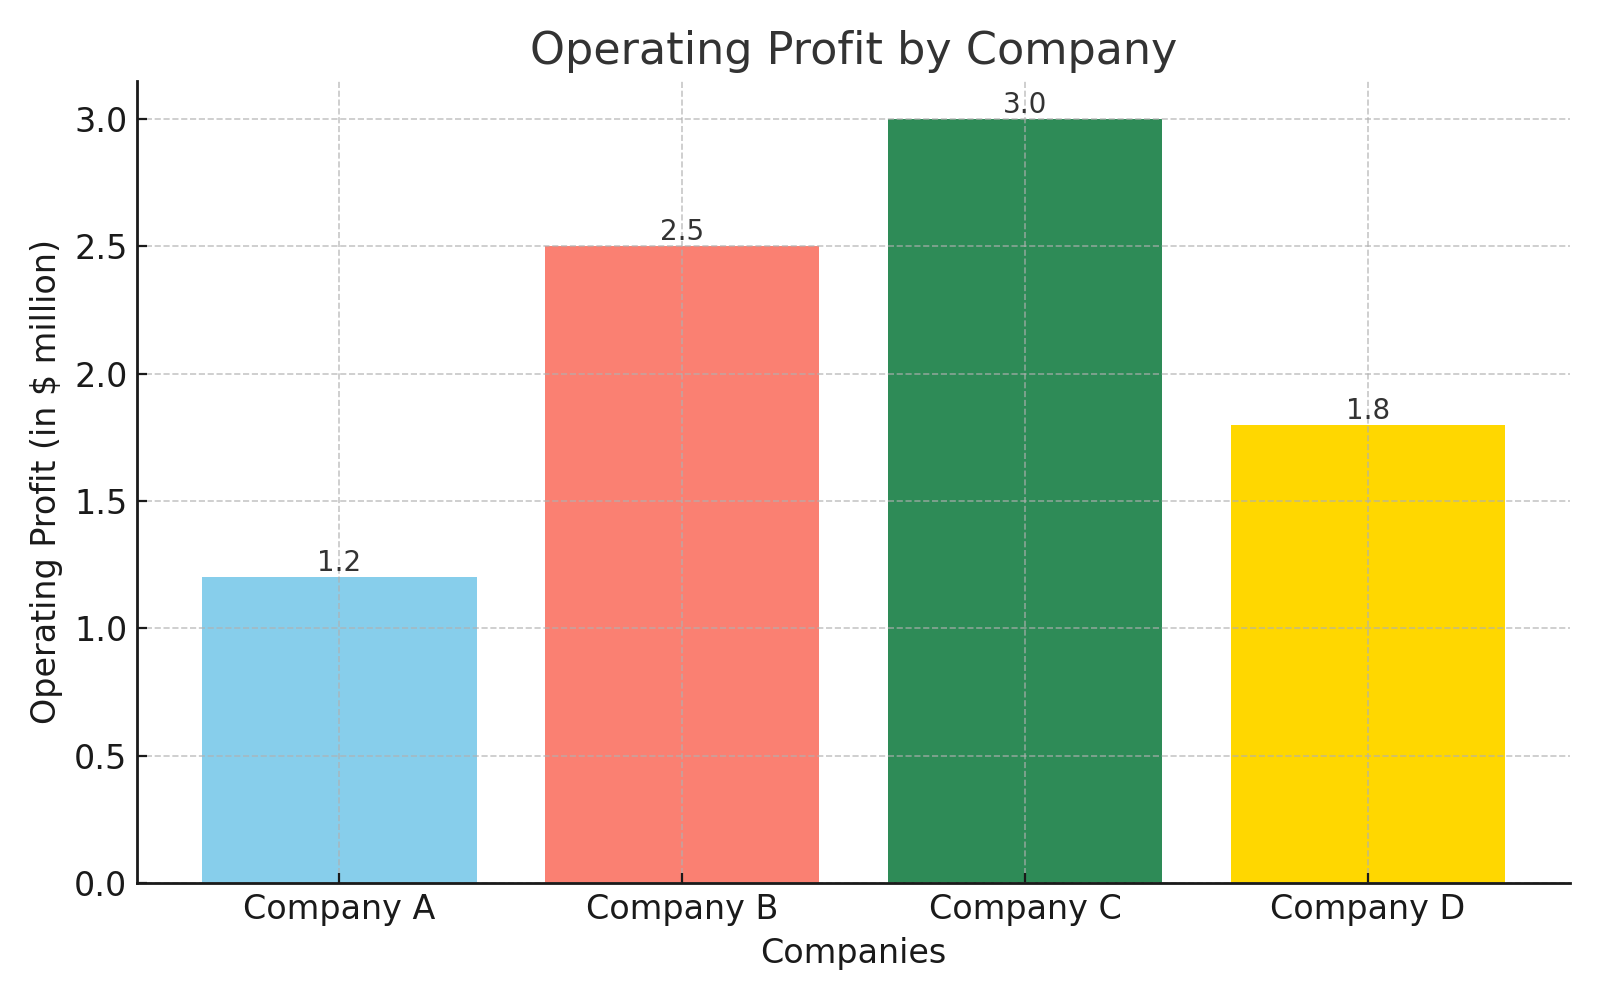

In [3]:
from IPython.display import display, HTML, JSON, Markdown, Image
display(Image(target_dir+file_name))